# Using a trained reflectorch model

In the first subsection, we show how to use the inference class (which abstracts away the implementation details) on experimental data.

In the last subsection, we illustrate some implementation details involved in using a trained model (which resembles the steps performed during the training process, including the generation of synthetic data). 

## Simplified use of a trained reflectorch model on experimental data

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r'C:/Users/Owner/Desktop/cw/COMP60660/reflectorch')
print(sys.path)

import reflectorch as reflectorch
print(reflectorch.__file__)

from reflectorch import EasyInferenceModel

torch.manual_seed(0); # set seed for reproducibility

['C:/Users/Owner/Desktop/cw/COMP60660/reflectorch', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\Owner\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages', 'C:\\Users\\Owner\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32', 'C:\\Users\\Owner\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\Owner\\AppData\\Loc

The `EasyInferenceModel` class simplifies the inference step for single reflectivity curves. We initialize the inference model by providing the name of the configuration file of a pretrained model (`config_name`), either with or without the '.yaml' extension. By default, the file name of the saved model weights for a specific configuration has the format 'model_' + config_name + extension (either '.pt' or '.safetensors'), but a different file name can be specified via the `model_name` argument. The `root_dir` argument can be used to specify a project directory containing the `configs` and `saved_models` subdirectories (containing the configurations and model weights, respectively), if different from the default package directory. The `weights_format` argument specifies the format (and extension) of the weights file, which can be either 'pt' (the default Pytorch weight format) or 'safetensors' (a weight format which addresses security risks associated with the default Pytorch weight format, as recommended for sharing via Huggingface). If the configuration or weights files are not found locally, they can be downloaded automatically from the Huggingface repository specified with the `repo_id` argument. Additionally, the `device` argument can be set to either `cuda` (for inference on the GPU) or `cpu` (for computers without a GPU with CUDA support).

We create and instance of the inference class, which also prints some details about the model such as the parameter ranges.

In [2]:
inference_model = EasyInferenceModel(config_name='b_mc_point_xray_conv_standard_L2_InputQ', #'mc25',
                                     model_name=None,
                                     root_dir=None,
                                     repo_id='valentinsingularity/reflectivity',
                                     device='cpu',
                                     )

Configuration file `C:\Users\Owner\Desktop\cw\COMP60660\reflectorch\configs\b_mc_point_xray_conv_standard_L2_InputQ.yaml` found locally.
Weights file `C:\Users\Owner\Desktop\cw\COMP60660\reflectorch\saved_models\model_b_mc_point_xray_conv_standard_L2_InputQ.safetensors` found locally.
Model b_mc_point_xray_conv_standard_L2_InputQ loaded. Number of parameters: 5.02 M
The model corresponds to a `standard_model` parameterization with 2 layers (8 predicted parameters)
Parameter types and total ranges:
- thicknesses: [1.0, 500.0]
- roughnesses: [0.0, 60.0]
- slds: [0.0, 50.0]
Allowed widths of the prior bound intervals (max-min):
- thicknesses: [0.01, 500.0]
- roughnesses: [0.01, 60.0]
- slds: [0.01, 5.0]
The model was trained on curves discretized at exactly 128 uniform points, between q_min in [0.001, 0.03] and q_max in [0.1, 0.4]
The following quantities are additional inputs to the network: prior bounds, q values.


We consider the following reflectivity curve (already preprocessed by standard procedures such as footprint correction):

In [3]:
data = np.loadtxt('C:/Users/Owner/Desktop/cw/COMP60660/reflectorch/exp_data/data_PTCDI-C3.txt', delimiter='\t', skiprows=1)
q_exp = data[..., 0]
curve_exp = data[..., 1]

print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())
print(data.shape)

(141,) (141,) 0.0142368058 0.213456644
(141, 2)


We interpolate the data to a discretization suitable for this model:

In [4]:
q_model, exp_curve_interp = inference_model.interpolate_data_to_model_q(q_exp, curve_exp)

print(q_model.shape, q_model.min(), q_model.max())
print(exp_curve_interp)

(128,) 0.0142368058 0.213456644
[9.82044589e-01 9.84793975e-01 9.95572077e-01 9.94149491e-01
 9.96742694e-01 9.95350459e-01 9.92007843e-01 9.89317448e-01
 9.74462849e-01 9.48963629e-01 8.77531972e-01 6.63643732e-01
 2.84186151e-01 1.02833002e-01 7.60089763e-02 6.54191640e-02
 5.48371931e-02 4.48919753e-02 3.48752903e-02 2.58944524e-02
 1.80637594e-02 1.19746238e-02 7.23368032e-03 4.05424186e-03
 2.00607051e-03 8.96698093e-04 4.08990729e-04 3.52997705e-04
 5.16558312e-04 7.76650600e-04 1.07490841e-03 1.33823356e-03
 1.47291899e-03 1.53524297e-03 1.51716627e-03 1.43033718e-03
 1.24104342e-03 1.08801319e-03 9.02510245e-04 7.21287545e-04
 5.23128598e-04 4.13515122e-04 3.01672376e-04 2.23264833e-04
 1.73402981e-04 1.52251190e-04 1.37394304e-04 1.37542894e-04
 1.42867384e-04 1.68158931e-04 1.62872293e-04 1.73692928e-04
 1.65094349e-04 1.75721471e-04 1.69398968e-04 1.62927235e-04
 1.59822574e-04 1.29613927e-04 1.19753315e-04 1.02481301e-04
 9.37261677e-05 8.37594626e-05 6.98552315e-05 6.13083

This is a measurement for a two-layer film in which we have some prior knowlede about the investigated system. We know the substrate is silicon on top of which sits a thin silicon oxide layer, followed by a perylene diimide (PTCDI-C3) layer. Thus, we can set narrow prior bounds for the scattering length densities (around known value for these materials) and for the thickness of the silicon oxide layer, but we set wide prior bounds for the roughnesses and for the thickness of the perylene diimide layer. We specify the prior bounds for the parameters as a list of tuples `(min_prior_bound, max_prior_bound)`. 

In [5]:
prior_bounds = [(1., 400.), (1., 10.), #layer thicknesses (top to bottom)
                (0., 20.), (0., 15.), (0., 15.), #interlayer roughnesses (top to bottom)
                (10., 13.), (20.,21.), (20., 21.)] #real layer slds (top to bottom)

Now, we can call the `predict` method of the inference model and provide as input the reflectivity curve and the prior bounds in order to obtain the neural network predictions. If the `clip_prediction` argument is `True`, the predictions are clipped to ensure they are not outside the interval defined by the prior bounds. If the `polish_prediction` argument is `True`, the predictions are further polished using a conventional least mean squares (LMS) fit. Additionally,  if `fit_growth` is also `True`, an additional parameter is introduced during the LMS polishing to account for the change in the thickness of the upper layer during the in-situ measurement of the reflectivity curve during film deposition (necessary when the aquisition rate is slow compared to the growth rate), the maximum possible change being given by the `max_d_change` argument. If the `use_q_shift` argument is `True`, the prediction is performed for a batch of slightly shifted versions of the input curve and the best result is returned, which is meant to mitigate the influence of imperfect sample alignment, as introduced in Greco et al. (*applicable only for models with fixed q-discretization*). The method returns a dictionary containing the predicted parameters (both as a BasicParams object and as a Numpy array). If `calc_pred_curve` is `True`, the reflectivity curve corresponding to the predicted parameters is also computed and added to the dictionary.

In [6]:
prediction_dict = inference_model.predict(
    reflectivity_curve=exp_curve_interp,
    prior_bounds=prior_bounds,
    q_values=q_model,
    clip_prediction=False,
    polish_prediction=True,
    use_q_shift=False,
    calc_pred_curve=True,
)
print(prediction_dict.keys())


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

dict_keys(['predicted_params_object', 'predicted_params_array', 'param_names', 'predicted_curve', 'polished_params_array', 'polished_curve'])


In [7]:
n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, pred_param_val, polished_param_val in zip(prediction_dict["param_names"], pred_params, prediction_dict["polished_params_array"]):
        print(f'{param_name.ljust(14)} -> Predicted: {pred_param_val:.2f}       Polished: {polished_param_val:.2f}')

Thickness L2   -> Predicted: 194.81       Polished: 187.78
Thickness L1   -> Predicted: 13.09       Polished: 1.00
Roughness L2   -> Predicted: 20.09       Polished: 20.00
Roughness L1   -> Predicted: 3.67       Polished: 3.39
Roughness sub  -> Predicted: 7.76       Polished: 13.30
SLD L2         -> Predicted: 11.65       Polished: 11.71
SLD L1         -> Predicted: 20.48       Polished: 20.00
SLD sub        -> Predicted: 20.54       Polished: 20.73


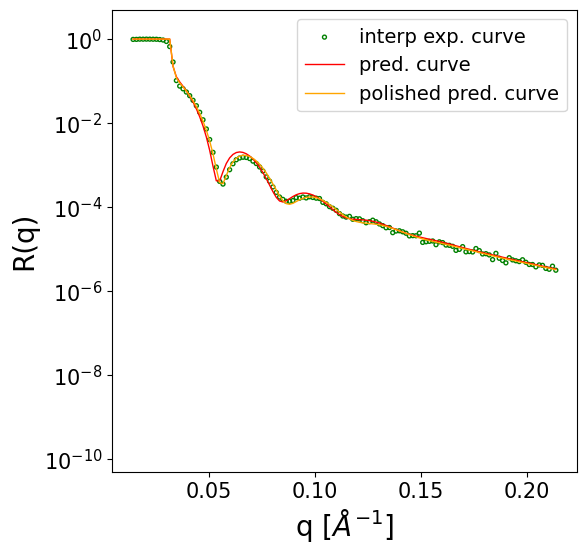

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
ax.scatter(q_model, exp_curve_interp, facecolors='none', edgecolors='green', s=8, label='interp exp. curve')  
ax.plot(q_model, pred_curve, c='r', lw=1, label='pred. curve')
ax.plot(q_model, prediction_dict['polished_curve'], c='orange', lw=1, label='polished pred. curve')

ax.legend(loc='upper right', fontsize=14);

Now we make a prediction for a similar structure, except that the top layer is fullerene (C60) instead. Thus we only change the prior bounds for the SLD of this layer.

In [9]:
data = np.loadtxt('../exp_data/data_C60.txt', delimiter='\t', skiprows=1)
q_exp = data[..., 0]
curve_exp = data[..., 1]

q_model, exp_curve_interp = inference_model.interpolate_data_to_model_q(q_exp, curve_exp)
#print(q_model.shape, q_model.min(), q_model.max())

prior_bounds = [(1., 400.), (1., 10.), #layer thicknesses (top to bottom)
                (0., 20.), (0., 15.), (0., 15.), #interlayer roughnesses (top to bottom)
                (13., 18.), (20.,21.), (20., 21.)] #real layer slds (top to bottom)

prediction_dict = inference_model.predict(reflectivity_curve=exp_curve_interp,
                                          prior_bounds=prior_bounds,
                                          q_values=q_model,
                                          clip_prediction=False,
                                          polish_prediction=True,
                                          use_q_shift=False,
                                          calc_pred_curve=True,
                                          )


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, pred_param_val, polished_param_val in zip(prediction_dict["param_names"], pred_params, prediction_dict["polished_params_array"]):
        print(f'{param_name.ljust(14)} -> Predicted: {pred_param_val:.2f}       Polished: {polished_param_val:.2f}')

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))

ax.scatter(q_model, exp_curve_interp, facecolors='none', edgecolors='green', s=8, label='interp exp. curve')  
ax.plot(q_model, pred_curve, c='r', lw=1, label='pred. curve')
ax.plot(q_model, prediction_dict['polished_curve'], c='orange', lw=1, label='polished pred. curve')

ax.legend(loc='upper right', fontsize=14);

FileNotFoundError: ../exp_data/data_C60.txt not found.

## Filtering available configuration files

The configuration files available on Huggingface can be filtered based on their properties using the `HuggingfaceQueryMatcher` class. We first initialize an instance of the query matcher which first downloads the configuration files to a temporary directory (it can take around 1 minute).

In [ ]:
from reflectorch import HuggingfaceQueryMatcher

hf_query_matcher = HuggingfaceQueryMatcher(repo_id='valentinsingularity/reflectivity')

Then we can provide a query (i.e. a dictionary of key-value pairs) as argument to its `get_matching_configs` method to get a list of configurations which match that query. The query should be formatted according to the hierarchical structure of the YAML configuration files (which are described in detail in the following sections of the documentation). 

For keys containing the ``param_ranges`` subkey a configuration is selected if the value of the query (i.e. desired parameter range) is a subrange of the parameter range in the configuration, in all other cases the values must match exactly.

In [2]:
query = {
    'dset.prior_sampler.kwargs.max_num_layers': 3,
    'dset.prior_sampler.kwargs.param_ranges.slds': [0., 100.],
}

matching_configs = hf_query_matcher.get_matching_configs(query)
for config in matching_configs:
    print(config)

Matching configuration files:
mc42.yaml
mc43.yaml
mc44.yaml
mc45.yaml


In [13]:
query = {
    'dset.prior_sampler.kwargs.max_num_layers': 2,
    'model.network.cls': 'NetworkWithPriorsFnoEmb',
    'model.network.kwargs.mlp_activation': 'gelu',
}

matching_configs = hf_query_matcher.get_matching_configs(query)
for config in matching_configs:
    print(config)

Matching configuration files:
mc-o1.yaml
mc-o10.yaml
mc-o11.yaml
mc-o12.yaml
mc-o2.yaml
mc-o3.yaml
mc-o4.yaml
mc-o5.yaml
mc-o7.yaml
mc-o8.yaml
mc-o9.yaml


## Detailed use of a reflectorch model on synthetic data

In [24]:
import torch
import matplotlib.pyplot as plt

from ipywidgets import interact
from reflectorch import get_trainer_by_name

torch.manual_seed(0); # set seed for reproducibility

In order to import a trained reflectorch model, we first have to specify the name of the trained model we wish to load. This name should match the name of the YAML configuration file used for training that model. Here we load a model for a 2-layer box (or slab) parameterization of the thin film SLD profile.

In [5]:

trained_model_name = 'b_mc_point_xray_conv_standard_L2_InputQ'
config_dir = "./reflectorch/configs"

In [2]:
trained_model_name = 'Test_v1'
config_dir = "./reflectorch/configs"

In [6]:

trained_model_name = 'mc1'
config_dir = "./reflectorch/configs"

Next, we initialize an instance of the `PointEstimatorTrainer` class using the `get_trainer_by_name` method.

:::{note}

The manner in which `get_trainer_by_name` is used above assumes that the configuration and weight files are available locally (e.g. such as after cloning the entire repository). If the package was installed in editable model, the configuration files are read from the `configs` directory located inside the repository directory, otherwise the path to the directory containing the configuration file should also be specified using the `config_dir` argument. The `load_weights` argument must be set to `True` in order for the saved weights of the neural network to be loaded, otherwise the network weights are randomly initialized.
:::

In [3]:
trainer = reflectorch.get_trainer_by_name(config_name=trained_model_name,config_dir = config_dir, load_weights = False)
callbacks = reflectorch.get_callbacks_by_name(trained_model_name)
trainer.model

Model Test_v1 loaded. Number of parameters: 7.60 M


NetworkWithPriorsConvEmb(
  (embedding_net): ConvEncoder(
    (core): Sequential(
      (0): Sequential(
        (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (1): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (2): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (3): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(ap

In [11]:
trainer = reflectorch.get_trainer_by_name(config_name=trained_model_name,config_dir = config_dir,  load_weights=True)
trainer.model

Model Test_v1 loaded. Number of parameters: 7.60 M


NetworkWithPriorsConvEmb(
  (embedding_net): ConvEncoder(
    (core): Sequential(
      (0): Sequential(
        (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (1): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (2): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (3): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(ap

In [11]:
trainer.train(num_batches=2000, callbacks=callbacks)
from safetensors.torch import save_file

torch.save(trainer.model.state_dict(), "C:/Users/Owner/Desktop/cw/COMP60660/reflectorch/saved_models/Test_v1_model.pt")
save_file(trainer.model.state_dict(), "C:/Users/Owner/Desktop/cw/COMP60660/reflectorch/saved_models/Test_v1_model.safetensors")

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Generating synthetic data

We can generate a batch of synthetic data using the `get_batch` method of the data loader:

In [4]:
batch_size = 64

trainer.loader.calc_denoised_curves = True
simulated_data = trainer.loader.get_batch(batch_size=batch_size)

In [5]:
simulated_data["backgrounds"]

KeyError: 'backgrounds'

This method returns a dictionary with 4 entries indexed by the following keys:

 1. **params** - an instance of the `BasicParams` class containing the physical (unscaled) values of the generated parameters, the generated minimum prior bound for each parameter and the generated maximum prior bound for each parameter (see the [paper](https://doi.org/10.1107/S1600576724002115) for more details about the generation process)
 2. **scaled_params** - a Pytorch Tensor containing the parameters, minimum bounds and maximum bounds, all scaled to the ML-friendly range [-1, 1]
 3. **q_values** - a Pytorch Tensor containing the reciprocal space (q) positions of the points in the reflectivity curve, in units of Å<sup>-1</sup>
 4. **scaled_noisy_curves** - a Pytorch Tensor containing the simulated reflectivity curves (including added noise) scaled to the ML-friendly range [-1, 1]
 5. **curves** - a Pytorch Tensor containing the (unscaled) theoretical reflectivity curves witout added noise. It is only computed if we set `trainer.loader.calc_denoised_curves` to `True` (which by default is `False`)

We can inspect one of the simulated curves:

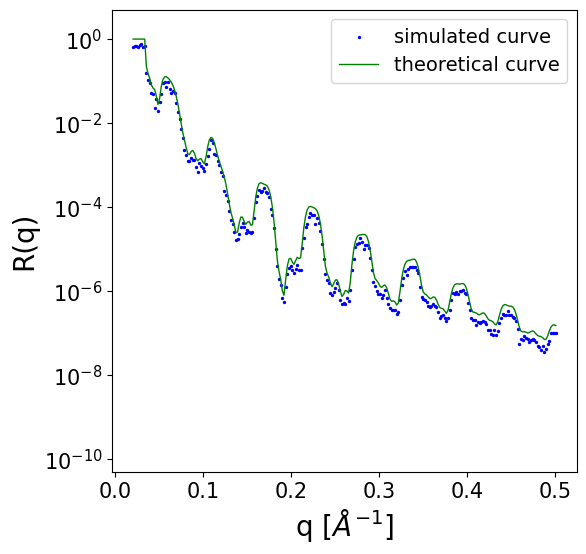

In [32]:
q = simulated_data['q_values']
scaled_noisy_curves = simulated_data['scaled_noisy_curves']
unscaled_noisy_curves = trainer.loader.curves_scaler.restore(scaled_noisy_curves)
unscaled_denoised_curve = simulated_data['curves']

def plot_refl_curve(i=0):
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    ax.set_yscale('log')
    ax.set_ylim(0.5e-10, 5)

    ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
    ax.set_ylabel('R(q)', fontsize=20)

    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    
    y_tick_locations = [10**(-2*i) for i in range(6)]
    ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
        
    ax.scatter(q[i].cpu().numpy(), unscaled_noisy_curves[i].cpu().numpy() + 1e-10, c='b', s=2, label='simulated curve')
    ax.plot(q[i].cpu().numpy(), unscaled_denoised_curve[i].cpu().numpy() + 1e-10, c='g', lw=1, label='theoretical curve')

    ax.legend(loc='upper right', fontsize=14)

plot_refl_curve(i=0)

This trained model corresponds to a 2 layer parameterization of the SLD profile (*in addition to the substrate*), which corresponds to 8 predicted film parameters:

In [33]:
n_layers = simulated_data['params'].max_layer_num
n_params = simulated_data['params'].num_params

print(f'Number of layers: {n_layers},  Number of film parameters: {n_params}')

Number of layers: 15,  Number of film parameters: 17


### Applying the model to synthetic data

The input to the neural network consists in the batch of reflectivity curves together with the prior bounds (minimum and maximum) for each film parameter. For experimental data, the prior bounds can be set according to the prior knowledge about the investigated thin film. In this example on simulated data, we use the prior bounds already sampled during the data generation process (i.e. meant for training the model) which ensures reasonable values for the prior bounds. 

In the `scaled_params` tensor the first 8 columns correspond to the *scaled* ground truth values of the film parameters, the next 8 columns to the *scaled* minimum bounds for the parameters and the last 8 to the *scaled* maximum bounds for the parameters. Thus, we select the last 16 columns as our input prior bounds:

In [34]:
scaled_bounds = simulated_data['scaled_params'][..., n_params:]

print(scaled_bounds[0])

tensor([ -2.3618,  -1.2376,  -1.0305,  -0.5125,  -1.9630,  -1.3559,  -0.6513,
         -0.3751,  -1.1556,  -0.9980,  -6.1503,  -1.5008,  -1.0492,  -0.9156,
         -0.2620, -11.2666, -12.8619,   3.3992,   1.0417,   1.1953,   0.9564,
          3.1550,   3.9736,   0.6095,   0.8063,   1.2006,   0.9827,   1.5498,
          1.0280,   1.5257,   0.8951,   0.4955,   1.5071,   4.6233],
       device='cuda:0', dtype=torch.float64)


In the case of a model trained with the q values as an additional input to the network, we also need the scaled q values:

In [35]:
print(trainer.train_with_q_input)
scaled_q_values = trainer.loader.q_generator.scale_q(q).to(torch.float32).float() if trainer.train_with_q_input else None

False


The neural network can be accessed as the `model` attribute of the trainer. By providing the scaled reflectivity curves and the scaled prior bounds as inputs to the network (and any other additional inputs which might be required for a specific model), we obtain the predictions for the parameters. We should also make sure that the input is of the `float` datatype.

:::{note}
The neural network must be first set to evaluation mode, as this influences the functionality of some neural network components such as the batch normalization layers.
:::

In [36]:
with torch.no_grad():
    trainer.model.eval()
    
    scaled_predicted_params = trainer.model(
        curves=scaled_noisy_curves.float(),
        bounds=scaled_bounds.float(),
        q_values = scaled_q_values,
    )
    
print(scaled_predicted_params.shape)

torch.Size([64, 17])


Now we need to restore the scaled predicted parameters to their unscaled (physical) values. Since the predicted parameters are scaled with respect to the input prior bounds, these are also required for the rescaling. We can concatenate the `scaled_predicted_params` and `scaled_bounds` tensors along the last tensor axis and provide them as input to the `restore_params` method of the prior sampler object (which can be accessed as `trainer.loader.prior_sampler`), the output being an instance of the `BasicParams` class.

In [37]:
restored_predictions = trainer.loader.prior_sampler.restore_params(torch.cat([scaled_predicted_params, scaled_bounds], dim=-1))
print(restored_predictions)

thickness_clamp = torch.clamp(restored_predictions.thicknesses , min=0.0)
roughness_clamp = torch.clamp(restored_predictions.roughnesses , min=0.0)

BasicParams(batch_size=64, max_layer_num=15, device=cuda:0)


The physical predictions can then be accessed using the corresponding attribute for each parameter type.

In [39]:
pred_idx = 0
print(f'Actual thicknesses: {simulated_data['params'].thicknesses[pred_idx]}')
print(f'Actual roughnesses: {simulated_data['params'].roughnesses[pred_idx]}')
print(f'Actual layer SLDs: {simulated_data['params'].slds[pred_idx]}')

print(f'Predicted thicknesses: {thickness_clamp[pred_idx]}')
print(f'Predicted roughnesses: {roughness_clamp[pred_idx]}')
print(f'Predicted layer SLDs: {restored_predictions.slds[pred_idx]}')

def loss(pred, true):
    percentage_error = torch.abs((true - pred) / (true + 1e-8))
    return torch.mean(percentage_error) * 100


def evaluate_model(pred_thickness, true_thickness,
                   pred_roughness, true_roughness,
                   pred_sld, true_sld):
    loss_thickness = loss(pred_thickness, true_thickness)
    loss_roughness = loss(pred_roughness, true_roughness)
    loss_sld = loss(pred_sld, true_sld)

    print(f"Thickness loss: {loss_thickness:.6f}")
    print(f"Roughness loss: {loss_roughness:.6f}")
    print(f"SLD loss: {loss_sld:.6f}")

    return loss_thickness, loss_roughness, loss_sld

loss_t, loss_r, loss_s = evaluate_model(
    restored_predictions.thicknesses[pred_idx], simulated_data['params'].thicknesses[pred_idx],
    restored_predictions.roughnesses[pred_idx], simulated_data['params'].roughnesses[pred_idx],
    restored_predictions.slds[pred_idx], simulated_data['params'].slds[pred_idx]
)

total_loss = loss_t+ loss_r+ loss_s
print(total_loss)

Actual thicknesses: tensor([14.0005, 55.0418, 43.6454, 14.0005, 55.0418, 43.6454, 14.0005, 55.0418,
        43.6454, 14.0005, 55.0418, 43.6454, 14.0005, 55.0418, 43.6454, 98.9581],
       device='cuda:0', dtype=torch.float64)
Actual roughnesses: tensor([ 4.4957, 11.8757, 12.2997,  4.4957, 11.8757, 12.2997,  4.4957, 11.8757,
        12.2997,  4.4957, 11.8757, 12.2997,  4.4957, 11.8757, 12.2997,  3.1873,
         5.4104], device='cuda:0', dtype=torch.float64)
Actual layer SLDs: tensor([ 2.7023,  3.9643,  5.8679,  7.7200, 10.0138, 14.7160, 12.9262, 13.5268,
        24.5939, 12.1969, 12.7629, 30.5064, 11.7124, 12.8225, 32.8494, 12.9893,
        23.1706], device='cuda:0', dtype=torch.float64)
Predicted thicknesses: tensor([20.3569, 80.4225, 36.1767, 20.3569, 80.4225, 36.1767, 20.3569, 80.4225,
        36.1767, 20.3569, 80.4225, 36.1767, 20.3569, 80.4225, 36.1767, 80.9529],
       device='cuda:0', dtype=torch.float64)
Predicted roughnesses: tensor([ 4.3344, 17.0004,  8.8228,  4.3344, 17.0004

Based on the predictions, we can easily simulate the corresponding reflectivity curves by using the `reflectivity` method of the previously obtained `BasicParams` object, which takes the q values as input:

In [40]:
predicted_curves = restored_predictions.reflectivity(q)

We can observe the input reflectivity curves alongside the curves corresponding to the neural network prediction. Additionally, we can print the prediction for each parameter alongside its ground truth value and its prior bounds.

In [41]:
from reflectorch import get_param_labels, get_density_profiles

#@interact(i=(0, batch_size-1, 1))
def plot_refl_curve(i=0):
    fig, ax = plt.subplots(1,2,figsize=(12,6))

    ax[0].set_yscale('log')
    ax[0].set_ylim(0.5e-10, 5)

    ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=20)
    ax[0].set_ylabel('R(q)', fontsize=20)

    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    
    y_tick_locations = [10**(-2*i) for i in range(6)]
    ax[0].yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
        
    ax[0].plot(q[i].cpu().numpy(), predicted_curves[i].cpu().numpy() + 1e-10, c='r', lw=1, label='prediction')
    ax[0].scatter(q[i].cpu().numpy(), unscaled_noisy_curves[i].cpu().numpy() + 1e-10, facecolors='none', edgecolors='blue', s=8, label='input sim. curve')

    ax[0].legend(loc='upper right', fontsize=14)

    z_axis = torch.linspace(-200, 1000, 1000, device='cuda')
    _, sld_profile_gt, _ = get_density_profiles(
         simulated_data['params'].thicknesses, 
         simulated_data['params'].roughnesses,
         simulated_data['params'].slds,
         z_axis=z_axis)
    
    _, sld_profile_pred, _ = get_density_profiles(
         thickness_clamp, 
         roughness_clamp,
         restored_predictions.slds,
         z_axis=z_axis)
    
    ax[1].plot(z_axis.cpu().numpy(), sld_profile_pred[i].cpu().numpy(), c='r', label='prediction')
    ax[1].plot(z_axis.cpu().numpy(), sld_profile_gt[i].cpu().numpy(), c='b', label='ground truth')

    ax[1].set_xlabel('z [$Å$]', fontsize=20)
    ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)

    plt.tight_layout()


    for l, t, p, min_b, max_b in zip(
          get_param_labels(n_layers),
          simulated_data['params'].parameters[i], 
          restored_predictions.parameters[i], 
          restored_predictions.min_bounds[i], 
          restored_predictions.max_bounds[i]
          ):
         print(f'{l.ljust(14)} --> True: {t:.2f} Predicted: {p:.2f}  Input prior bounds: ({min_b:.2f}, {max_b:.2f})')

Thickness L15  --> True: 8.96 Predicted: 8.59  Input prior bounds: (5.28, 16.80)
Thickness L14  --> True: 2.32 Predicted: 1.62  Input prior bounds: (0.20, 3.05)
Thickness L13  --> True: 0.65 Predicted: 0.65  Input prior bounds: (0.19, 0.75)
Thickness L12  --> True: 14.00 Predicted: 20.36  Input prior bounds: (13.66, 24.67)
Thickness L11  --> True: 55.04 Predicted: 80.42  Input prior bounds: (30.37, 81.55)
Thickness L10  --> True: 43.65 Predicted: 36.18  Input prior bounds: (18.22, 44.87)
Thickness L9   --> True: 4.50 Predicted: 4.33  Input prior bounds: (2.16, 8.15)
Thickness L8   --> True: 11.88 Predicted: 17.00  Input prior bounds: (9.44, 27.10)
Thickness L7   --> True: 12.30 Predicted: 8.82  Input prior bounds: (2.91, 19.40)
Thickness L6   --> True: 12.03 Predicted: 15.95  Input prior bounds: (5.02, 19.87)
Thickness L5   --> True: 13.17 Predicted: 63.64  Input prior bounds: (8.50, 85.50)
Thickness L4   --> True: 33.88 Predicted: 52.78  Input prior bounds: (18.74, 50.35)
Thickness L3

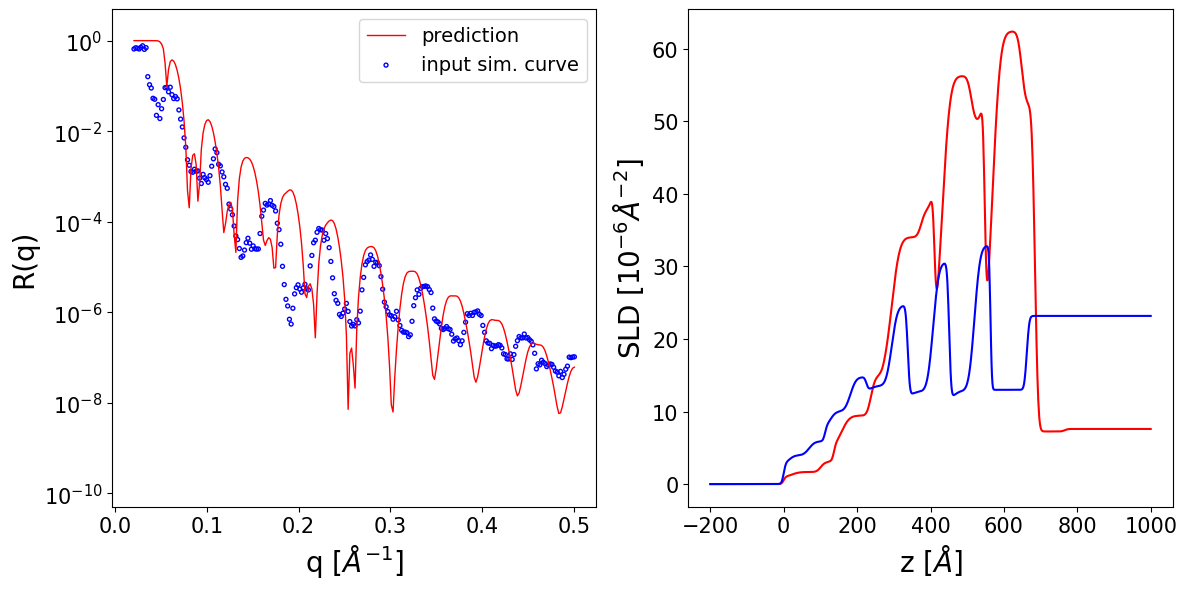

In [15]:
plot_refl_curve(i=0)

Thickness L15  --> True: 16.38 Predicted: 10.38  Input prior bounds: (7.93, 16.67)
Thickness L14  --> True: 1.40 Predicted: 1.09  Input prior bounds: (0.60, 1.48)
Thickness L13  --> True: 0.38 Predicted: 0.52  Input prior bounds: (0.17, 0.74)
Thickness L12  --> True: 24.63 Predicted: 23.78  Input prior bounds: (7.38, 25.44)
Thickness L11  --> True: 70.49 Predicted: 73.18  Input prior bounds: (39.41, 81.67)
Thickness L10  --> True: 34.92 Predicted: 33.41  Input prior bounds: (15.57, 36.86)
Thickness L9   --> True: 3.61 Predicted: 5.81  Input prior bounds: (0.76, 9.85)
Thickness L8   --> True: 12.10 Predicted: 20.29  Input prior bounds: (8.10, 26.03)
Thickness L7   --> True: 6.47 Predicted: 7.26  Input prior bounds: (4.11, 9.89)
Thickness L6   --> True: 11.05 Predicted: 13.10  Input prior bounds: (7.34, 16.39)
Thickness L5   --> True: 66.72 Predicted: 75.81  Input prior bounds: (34.71, 99.58)
Thickness L4   --> True: 47.00 Predicted: 51.26  Input prior bounds: (20.23, 51.42)
Thickness L3

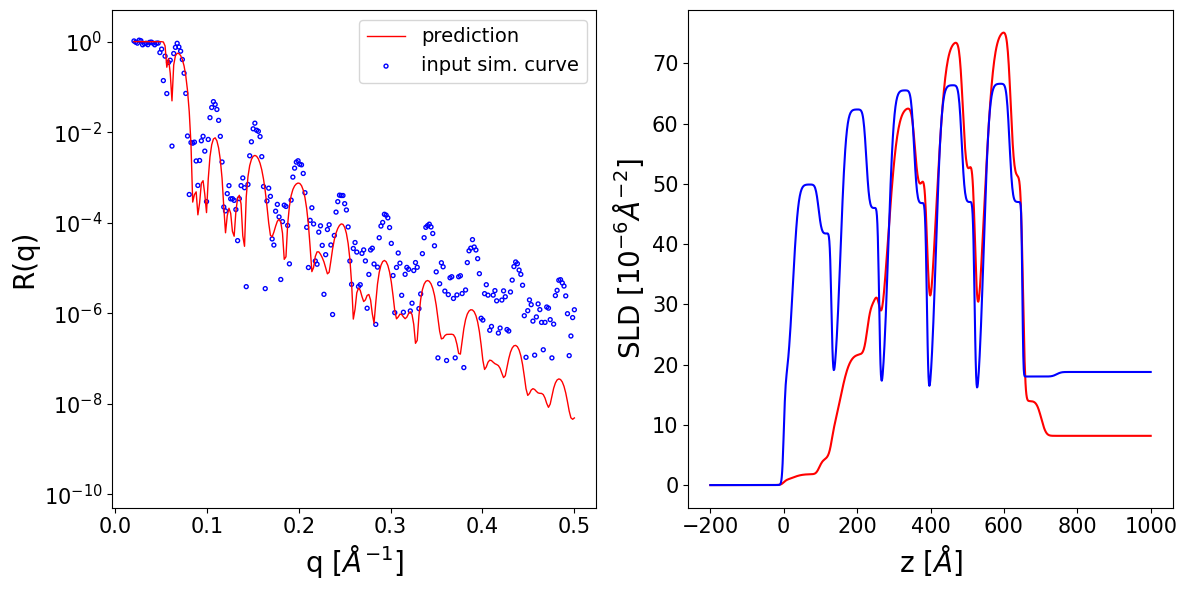

In [16]:
plot_refl_curve(i=30)

Thickness L15  --> True: 13.94 Predicted: 6.88  Input prior bounds: (3.29, 14.29)
Thickness L14  --> True: 2.99 Predicted: 1.46  Input prior bounds: (0.47, 3.03)
Thickness L13  --> True: 0.41 Predicted: 0.60  Input prior bounds: (0.39, 0.69)
Thickness L12  --> True: 4.79 Predicted: 21.49  Input prior bounds: (1.19, 25.44)
Thickness L11  --> True: 54.41 Predicted: 68.67  Input prior bounds: (24.46, 82.26)
Thickness L10  --> True: 20.90 Predicted: 35.80  Input prior bounds: (9.73, 39.68)
Thickness L9   --> True: 4.57 Predicted: 5.69  Input prior bounds: (3.97, 7.46)
Thickness L8   --> True: 25.84 Predicted: 23.79  Input prior bounds: (19.99, 26.55)
Thickness L7   --> True: 4.58 Predicted: 10.77  Input prior bounds: (4.14, 14.61)
Thickness L6   --> True: 12.23 Predicted: 13.64  Input prior bounds: (5.01, 19.82)
Thickness L5   --> True: 56.52 Predicted: 93.72  Input prior bounds: (51.38, 120.38)
Thickness L4   --> True: 51.07 Predicted: 54.12  Input prior bounds: (18.45, 67.19)
Thickness L

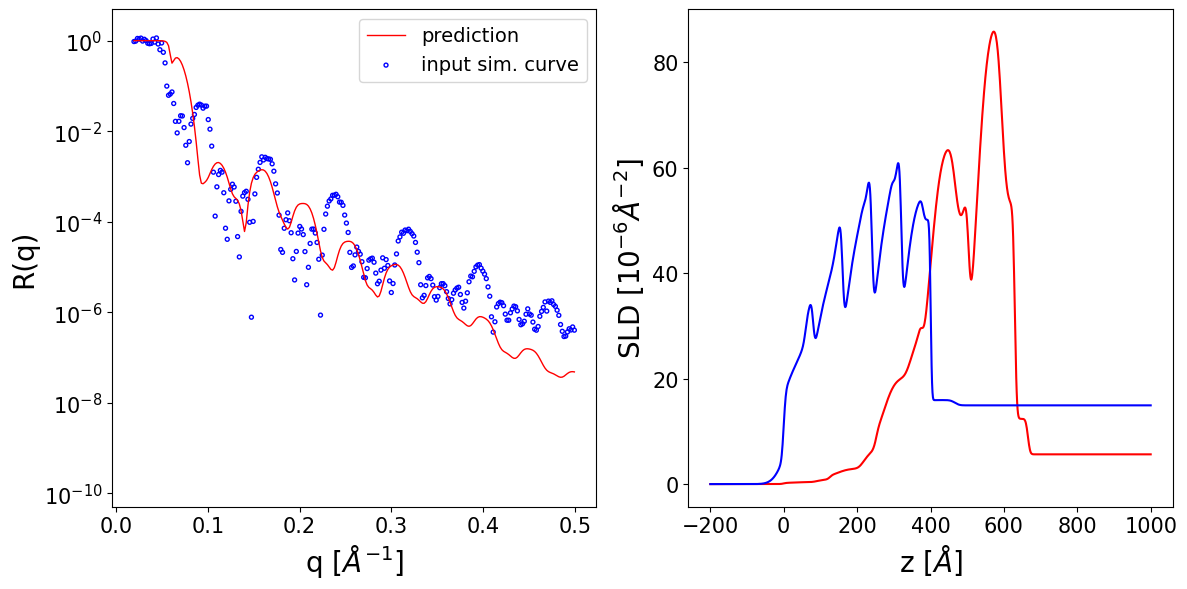

In [17]:
plot_refl_curve(i=45)

In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

def init():
    ax[0].set_yscale('log')
    ax[0].set_ylim(0.5e-10, 5)
    ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=20)
    ax[0].set_ylabel('R(q)', fontsize=20)
    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    y_tick_locations = [10**(-2*i) for i in range(6)]
    ax[0].yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))

    ax[1].set_xlabel('z [$Å$]', fontsize=20)
    ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)
    
    return []

def update(i):
    ax[0].clear()
    ax[1].clear()
    
    ax[0].set_yscale('log')
    ax[0].set_ylim(0.5e-10, 5)
    ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=20)
    ax[0].set_ylabel('R(q)', fontsize=20)
    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    y_tick_locations = [10**(-2*j) for j in range(6)]
    ax[0].yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
    ax[0].plot(q[i].cpu().numpy(), predicted_curves[i].cpu().numpy() + 1e-10, 
               c='r', lw=1, label='prediction')
    ax[0].scatter(q[i].cpu().numpy(), unscaled_noisy_curves[i].cpu().numpy() + 1e-10, 
                  facecolors='none', edgecolors='blue', s=8, label='input sim. curve') 
    ax[0].legend(loc='upper right', fontsize=14)

    z_axis = torch.linspace(-200, 1000, 1000, device='cpu')  # or device='cuda'
    _, sld_profile_gt, _ = get_density_profiles(
         simulated_data['params'].thicknesses[i:i+1].cpu(),
         simulated_data['params'].roughnesses[i:i+1].cpu(),
         simulated_data['params'].slds[i:i+1].cpu(),
         z_axis=z_axis)

    _, sld_profile_pred, _ = get_density_profiles(
         thickness_clamp[i:i+1].cpu(),
         roughness_clamp[i:i+1].cpu(),
         restored_predictions.slds[i:i+1].cpu(),
         z_axis=z_axis)
    
    ax[1].plot(z_axis.cpu().numpy(), sld_profile_pred[0].cpu().numpy(), 
               c='r', label='prediction')
    ax[1].plot(z_axis.cpu().numpy(), sld_profile_gt[0].cpu().numpy(), 
               c='b', label='ground truth')
    ax[1].set_xlabel('z [$Å$]', fontsize=20)
    ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)
    ax[1].legend(loc='upper right', fontsize=14)
    
    return []

anim = FuncAnimation(fig, update, frames=range(batch_size), 
                     init_func=init, blit=False)
plt.close(fig)

from IPython.display import HTML
HTML(anim.to_jshtml())

In [65]:
test_model = EasyInferenceModel(config_name='Test_v1',
                                     model_name='Test_v1_model',
                                     root_dir=None,
                                     repo_id='valentinsingularity/reflectivity',
                                     device='cpu',
                                    )

i = 52

max_bounds = simulated_data['params'].max_bounds.cpu().numpy()
min_bounds = simulated_data['params'].min_bounds.cpu().numpy()
prior_bounds = [(np.float32(min_v), np.float32(max_v)) for min_v, max_v in zip(min_bounds[i], max_bounds[i])]

reflectivity_curve = np.array(unscaled_denoised_curve[i].cpu().numpy(), dtype=np.float32)
q_values = np.array(q[i].cpu().numpy(), dtype=np.float32)

prediction_dict_a = test_model.predict(
    reflectivity_curve=reflectivity_curve,
    q_values = q_values,
    prior_bounds = prior_bounds,
    clip_prediction=False,
    polish_prediction=True,
    use_q_shift=False,
    calc_pred_curve=True,
)

print(prediction_dict_a.keys())


pred_params_a = prediction_dict_a['predicted_params_array']
pred_curve_a = prediction_dict_a['predicted_curve']

Configuration file `C:\Users\Owner\Desktop\cw\COMP60660\reflectorch\configs\Test_v1.yaml` found locally.
Weights file `C:\Users\Owner\Desktop\cw\COMP60660\reflectorch\saved_models\Test_v1_model.safetensors` found locally.
Model Test_v1 loaded. Number of parameters: 7.60 M
The model corresponds to a `repeating_multilayer_abc` parameterization with 15 layers (17 predicted parameters)
Parameter types and total ranges:
- d_sig: [8, 12]
- width_sigmas: [0.5, 3.0]
- k: [0.2, 0.7]
- d_A: [10, 25]
- d_B: [40, 60]
- d_C: [20, 30]
- s_A: [0.5, 10.0]
- s_B: [0.1, 30.0]
- s_C: [4.0, 18.0]
- sld_A: [5.0, 20.0]
- sld_B: [60.0, 80.0]
- sld_C: [25.0, 50.0]
- d_sio2: [50.0, 90.0]
- s_sio2: [0.1, 6.0]
- s_si: [0.1, 12.0]
- sld_sio2: [12.0, 14.0]
- sld_si: [20.5, 23.0]
Allowed widths of the prior bound intervals (max-min):
- d_sig: [8, 12]
- width_sigmas: [0.5, 3.0]
- k: [0.2, 0.7]
- d_A: [10, 25]
- d_B: [40, 60]
- d_C: [20, 30]
- s_A: [0.5, 10.0]
- s_B: [0.1, 30.0]
- s_C: [4.0, 18.0]
- sld_A: [5.0, 20.0

In [66]:
n_layers = test_model.trainer.loader.prior_sampler.max_num_layers
for param_name, pred_param_val, polished_param_val in zip(prediction_dict_a["param_names"], pred_params_a, prediction_dict_a["polished_params_array"]):
        print(f'{param_name.ljust(14)} -> Predicted: {pred_param_val:.2f}       Polished: {polished_param_val:.2f}')

d_sig          -> Predicted: 8.81       Polished: 10.06
width_sigmas   -> Predicted: 1.54       Polished: 1.63
k              -> Predicted: 0.37       Polished: 0.27
d_A            -> Predicted: 14.59       Polished: 16.50
d_B            -> Predicted: 44.86       Polished: 50.05
d_C            -> Predicted: 25.44       Polished: 17.45
s_A            -> Predicted: 5.50       Polished: 5.45
s_B            -> Predicted: 10.41       Polished: 8.84
s_C            -> Predicted: 13.21       Polished: 11.67
sld_A          -> Predicted: 15.29       Polished: 21.70
sld_B          -> Predicted: 21.46       Polished: 27.12
sld_C          -> Predicted: 15.01       Polished: 15.32
d_sio2         -> Predicted: 108.63       Polished: 104.27
s_sio2         -> Predicted: 4.80       Polished: 4.34
s_si           -> Predicted: 5.04       Polished: 4.99
sld_sio2       -> Predicted: 10.30       Polished: 11.57
sld_si         -> Predicted: 22.00       Polished: 22.70


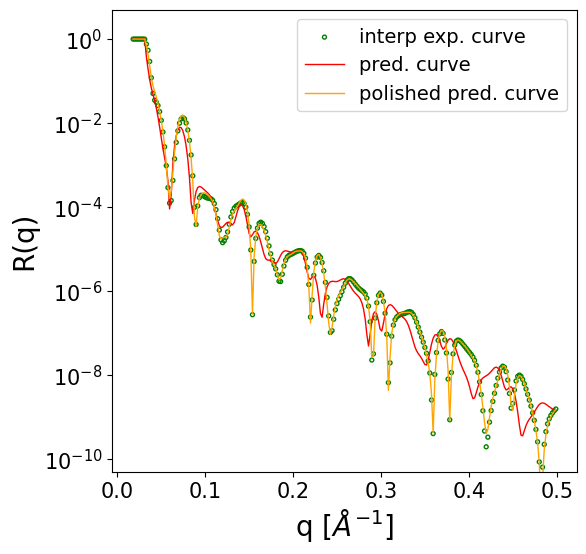

In [67]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
ax.scatter(q_values, reflectivity_curve, facecolors='none', edgecolors='green', s=8, label='interp exp. curve')  
ax.plot(q_values, pred_curve_a, c='r', lw=1, label='pred. curve')
ax.plot(q_values, prediction_dict_a['polished_curve'], c='orange', lw=1, label='polished pred. curve')

ax.legend(loc='upper right', fontsize=14)

In [68]:
def mse(curve_pred, curve_true):
    return np.mean((curve_pred - curve_true)**2)

mse1 = mse(pred_curve_a, reflectivity_curve)
mse2 = mse(prediction_dict_a['polished_curve'], reflectivity_curve)

print(f"Error for prediction {mse1}")
print(f"Error for polished prediction {mse2}")

if mse1 < mse2:
    print("Prediction is closer")
else:
    print("Polished Prediction is closer")

Error for prediction 0.0011639022002522795
Error for polished prediction 7.769228424658616e-05
Polished Prediction is closer
